# Comparação entre Abordagens de Visão Computacional (YOLOv5, YOLO Tradicional e CNN)  
### Referente à Entrega 2 do Projeto PBL - Fase 6


Nesta segunda etapa, o objetivo é comparar diferentes abordagens de visão computacional aplicadas ao mesmo conjunto de dados utilizado na Entrega 1. A proposta é identificar vantagens e limitações entre técnicas de detecção e classificação baseadas em redes neurais.

As abordagens implementadas são:

1. YOLOv5 Adaptado (já treinado na Entrega 1)
2. YOLO Tradicional (modelo pré-treinado, sem ajustes)
3. CNN desenvolvida do zero (classificação entre duas classes)

A análise comparativa será baseada em critérios como precisão, tempo de inferência, facilidade de implementação e aplicabilidade prática.


### Referência: Resultado da Entrega 1 (YOLOv5 Adaptado - 60 épocas)


Nesta etapa, utilizaremos como referência comparativa o modelo YOLOv5 treinado com 60 épocas, desenvolvido na Entrega 1.

Esse modelo obteve os seguintes resultados:

- Tempo de treinamento: **268 segundos**
- Tempo de inferência: **7,72 segundos**
- Detecção correta em **7 de 8 imagens** do conjunto de teste
- **mAP@0.5**: ~1.0
- **mAP@0.5:0.95**: ~0.7

Abaixo está o gráfico de métricas gerado durante o treinamento deste modelo.

Gráfico de desempenho do modelo YOLOv5 (60 épocas):


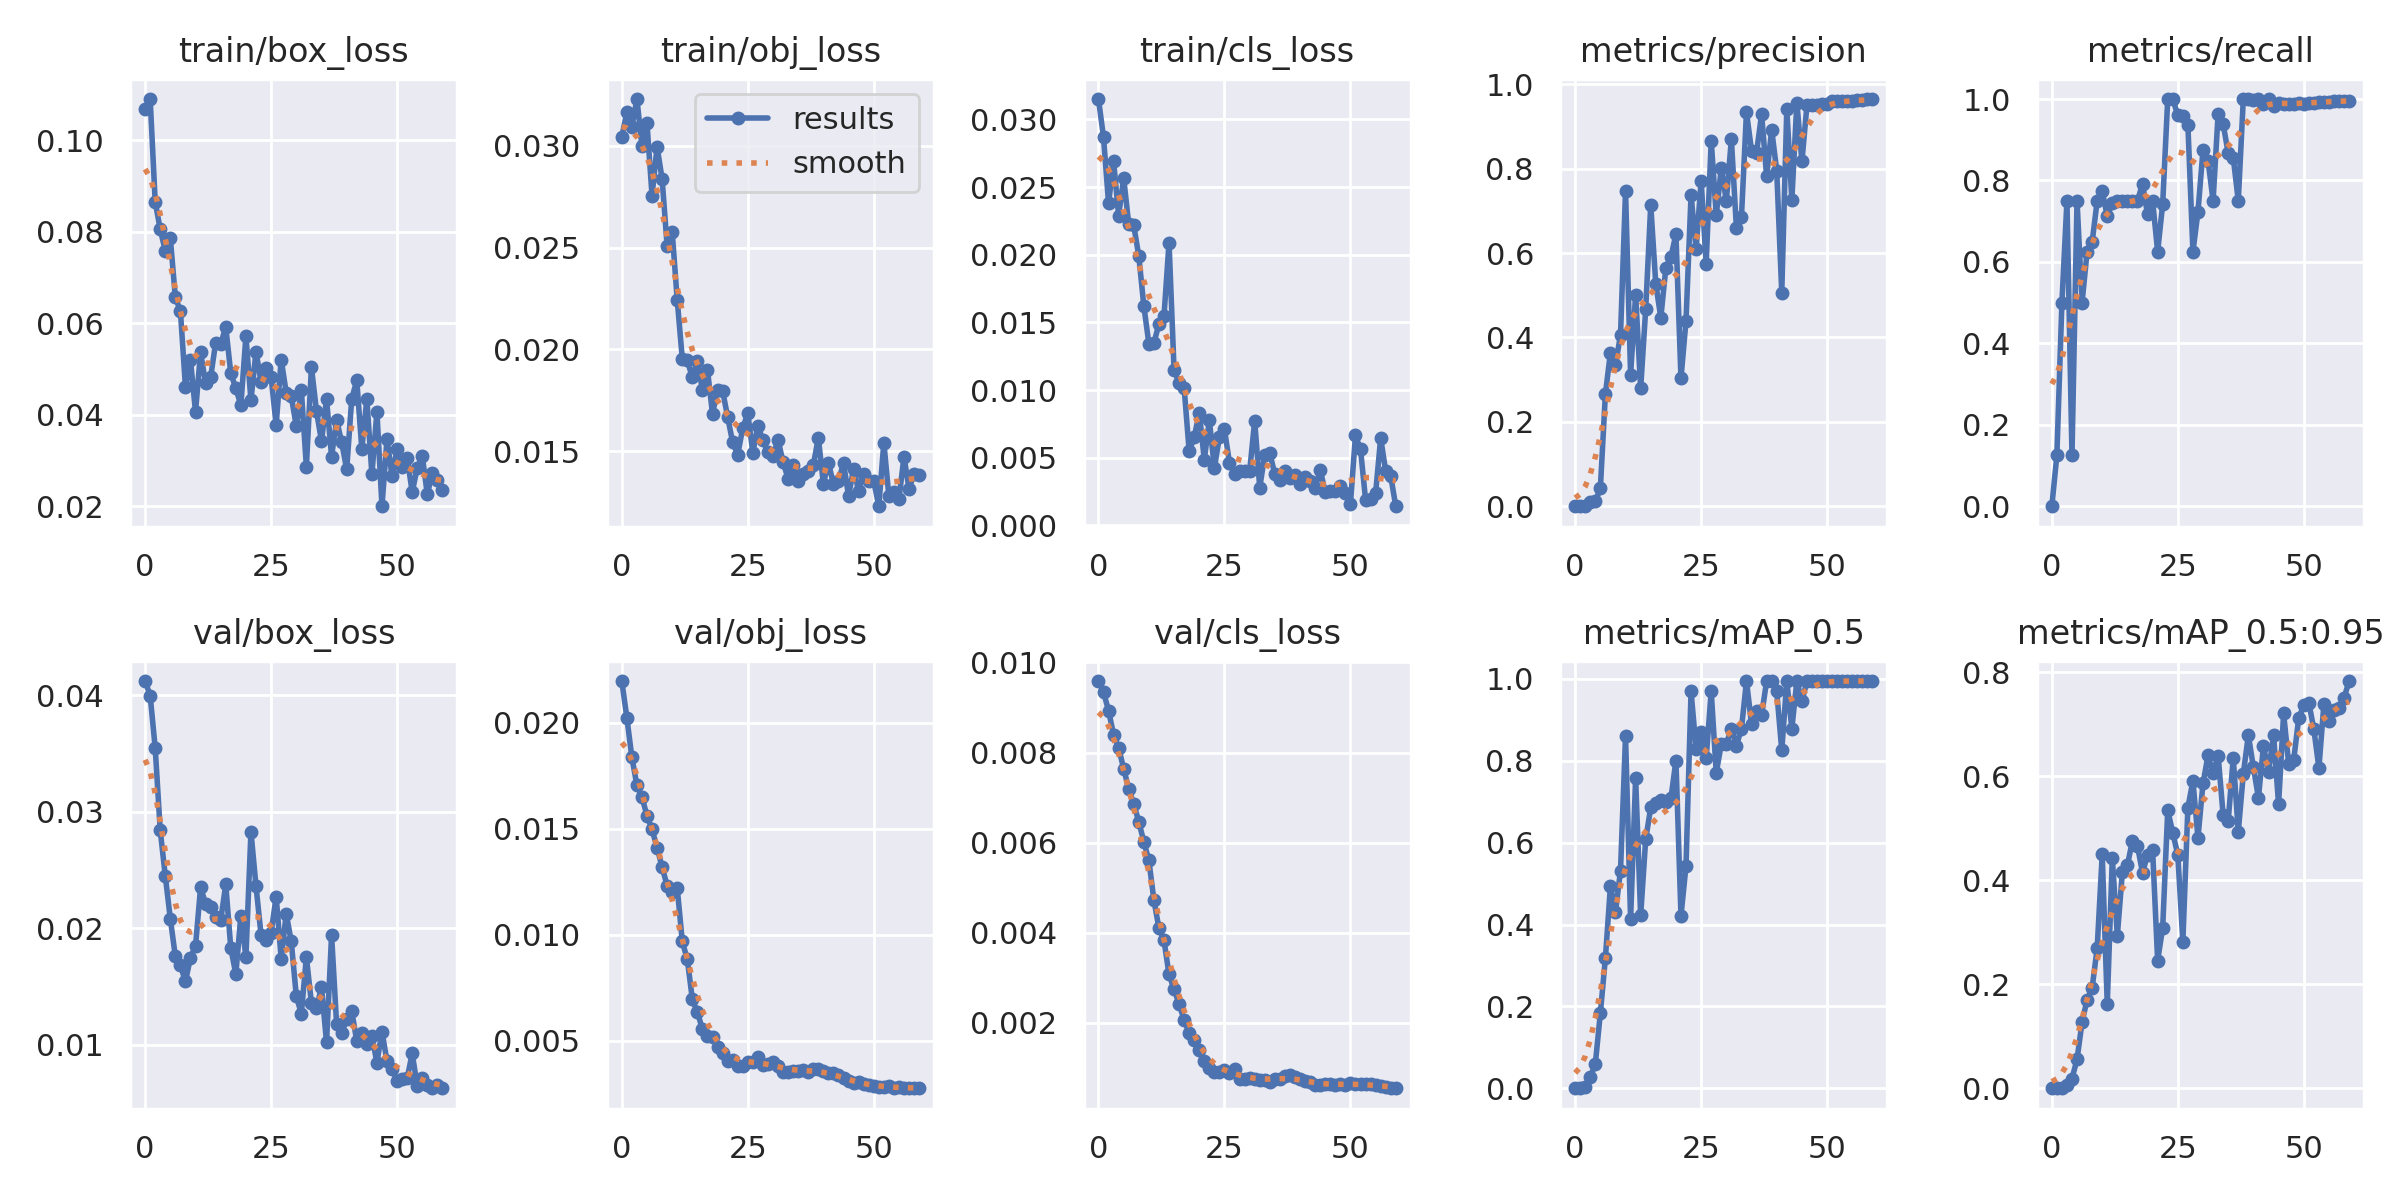

In [ ]:
from IPython.display import Image, display

# Exibir gráfico de métricas
print("Gráfico de desempenho do modelo YOLOv5 (60 épocas):")
display(Image(filename=f'./yolov5/runs/train/{nome_treinamento}/results.png', width=1200))


## 1. Aplicação da YOLOv5 Tradicional (Pré-treinada)

Nesta abordagem, utilizamos o modelo `yolov5s.pt` fornecido pela Ultralytics, sem ajustes no dataset customizado.

Este modelo já foi treinado em um grande conjunto de dados públicos (COCO dataset), o que lhe permite detectar diversas classes genéricas. O objetivo aqui é avaliar se ele é capaz de identificar **carros** e **motos** em nosso conjunto de teste, mesmo sem ter sido adaptado para essas imagens específicas.

Esta etapa também permite comparar como um modelo genérico se comporta frente a um modelo customizado, como o desenvolvido na Entrega 1.

In [ ]:
import time

nome_treinamento = "yolo_tradicional"

# Parâmetros utilizados:
# --weights: define o modelo YOLOv5 a ser utilizado (pré-treinado 'yolov5s.pt')
# --img: tamanho da imagem de entrada (640x640 pixels)
# --conf: nível mínimo de confiança para considerar uma detecção
# --source: diretório com as imagens do conjunto de teste
# --name: nome da pasta onde os resultados da inferência serão salvos (dentro de runs/detect/)

# Marca o início da execução
inicio = time.time()

# Executa a inferência com o modelo pré-treinado
!python ./yolov5/detect.py \
  --weights yolov5s.pt \
  --img 640 \
  --conf 0.25 \
  --source {dataset_dir}/dataset_images/images/test \
  --name {nome_treinamento}_test

# Marca o fim da execução e calcula a duração
fim = time.time()
print(f"Tempo de inferência com YOLO pré-treinado: {fim - inicio:.2f} segundos")


detect: weights=['yolov5s.pt'], source=/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_tradicional_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test/Imagem073.jpg: 480x640 3 cars, 1 motorcycle, 50.3ms
image 2/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_im

### Visualização dos resultados da YOLOv5 Tradicional

Abaixo estão algumas imagens do conjunto de teste processadas pelo modelo pré-treinado YOLOv5s. O objetivo é observar quais objetos foram detectados, como foram classificados e se há consistência nas detecções para as classes de interesse (carro e moto).


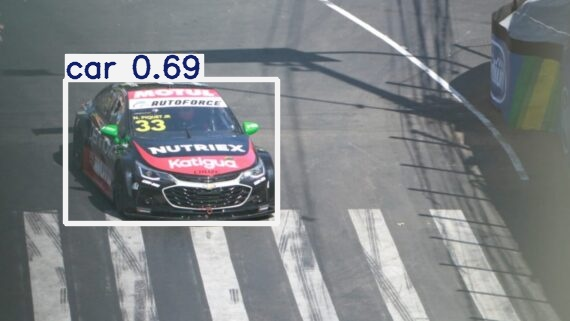

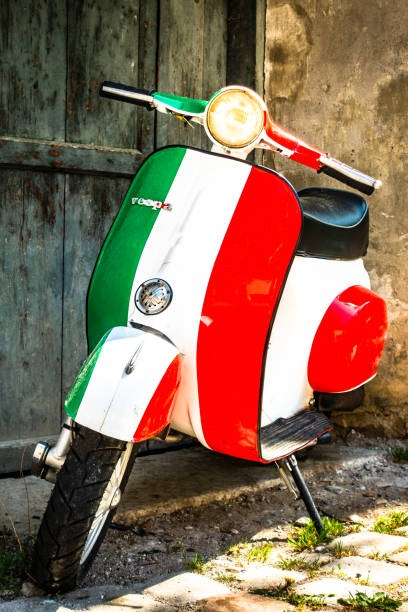

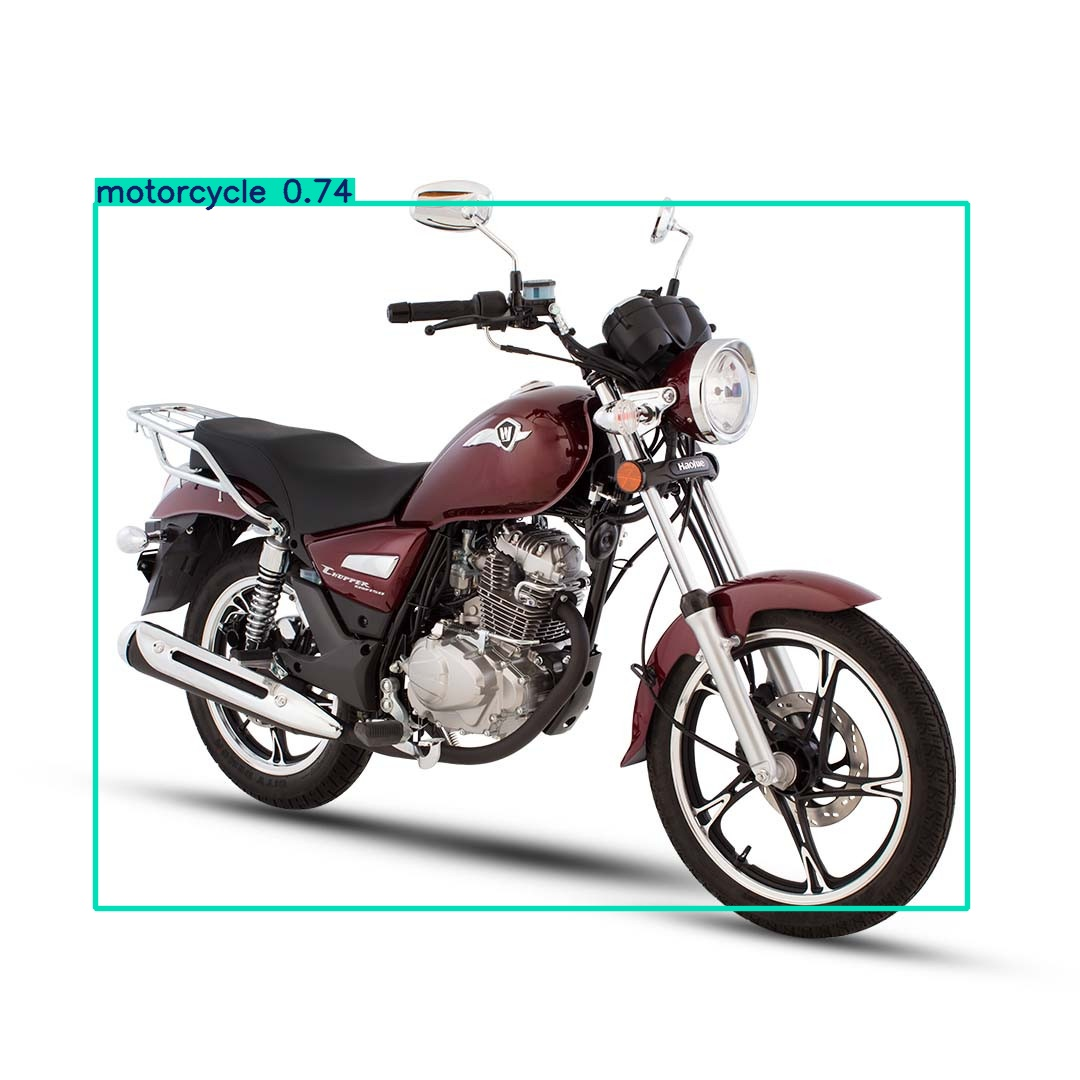

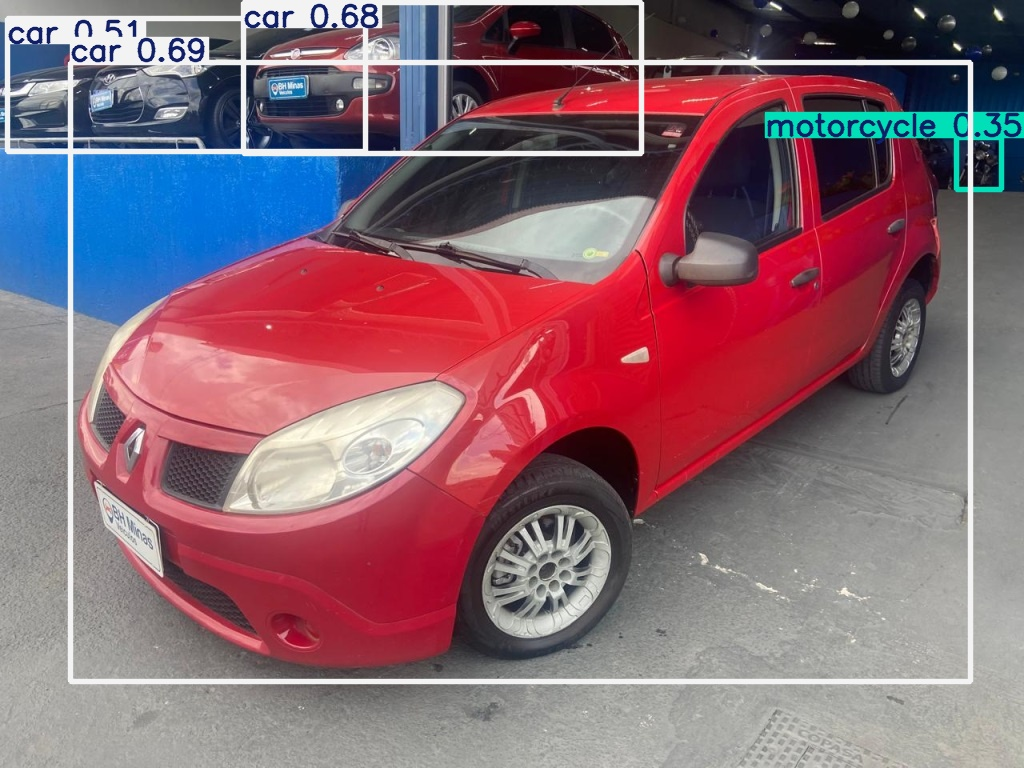

In [ ]:
from IPython.display import Image, display
import glob

# Local dos resultados gerados pelo YOLO pré-treinado
imagens_yolo_tradicional = glob.glob(f'./yolov5/runs/detect/{nome_treinamento}_test/*.jpg')

# Exibir até 4 imagens
for img_path in imagens_yolo_tradicional[:4]:
    display(Image(filename=img_path, width=500))


### Análise de desempenho do modelo YOLOv5 Tradicional (Pré-treinado)


Ao aplicar o modelo YOLOv5s pré-treinado (sem re-treinamento) sobre as imagens do conjunto de teste, foram observadas as seguintes características e comportamentos:

#### 🔹 Detecções realizadas
- O modelo foi capaz de detectar **carros** e **motos**, que são classes presentes no dataset COCO (base de treinamento do YOLOv5 pré-treinado).
- Em algumas imagens, foi capaz de detectar **mais de um objeto da mesma classe**, como múltiplos carros ou motos, demonstrando uma boa capacidade de identificação em ambientes com múltiplas ocorrências.
- Algumas imagens apresentaram **detecções incorretas ou irrelevantes**, como a classificação de "train" ou "truck", indicando limitações no foco da aplicação.

#### 🔹 Acertos e limitações por imagem
- **Imagem 073**: Detecção de 3 carros e 1 moto, indicando boa sensibilidade.
- **Imagem 074**: Detecção incorreta como "train", devido à vista traseira incomum do fusca.
- **Imagem 075**: Detecção correta de um carro.
- **Imagem 076**: Detecção como "truck" (possivelmente confundido com o design do Tesla Cybertruck).
- **Imagem 077**: Detecção correta de uma moto.
- **Imagem 078**: Detecção de 4 motos, indicando alta sensibilidade, mas possível excesso.
- **Imagem 079**: Detecção correta de uma moto.
- **Imagem 080**: Nenhuma detecção (moto tipo Vespa, possivelmente fora do padrão aprendido).

#### 🔹 Tempo de inferência
- O tempo total de inferência foi de aproximadamente **7,84 segundos** para processar as 8 imagens do conjunto de teste.
- A média de tempo por imagem foi de aproximadamente **23,8 ms de inferência** e **18,7 ms de NMS**, o que representa uma performance adequada para aplicações em tempo real ou embarcadas.

#### 🔹 Robustez e generalização
- O modelo demonstrou **capacidade de generalizar** bem para contextos diversos, sendo capaz de detectar objetos mesmo em imagens não padronizadas.
- A presença de falsos positivos e detecções de classes fora do escopo do projeto reforça o caráter **genérico** do modelo.

Esses resultados demonstram que o modelo YOLOv5 pré-treinado, mesmo sem ajustes, consegue fornecer **resultados relevantes** em ambientes variados, desde que as classes estejam contempladas em seu conjunto de treinamento original.


### Conclusão parcial – YOLOv5 Tradicional (Pré-treinado)

O modelo YOLOv5s pré-treinado, utilizado sem re-treinamento, apresentou um desempenho satisfatório ao ser aplicado diretamente sobre as imagens do conjunto de teste do projeto.

Mesmo sem ter sido treinado com o dataset específico, o modelo foi capaz de detectar corretamente diversas ocorrências das classes "car" e "motorcycle", mostrando uma boa generalização para objetos presentes em seu dataset original (COCO).

Além disso, o modelo demonstrou:
- **Capacidade de identificar múltiplos objetos por imagem**, o que é relevante em ambientes complexos.
- **Tempo de inferência adequado** (7,84 segundos para 8 imagens), tornando-o viável para aplicações práticas.
- **Alguns falsos positivos ou classificações irrelevantes**, como "train" e "truck", esperados em um modelo genérico.

Por outro lado, a detecção incorreta de objetos incomuns (como o Tesla Cybertruck ou a traseira aberta de um fusca) e a ausência de detecção em casos menos padronizados (como a moto Vespa) indicam **limitações relacionadas à representatividade do dataset de origem** e à falta de especialização no domínio do projeto.

Em resumo, o YOLO pré-treinado é uma ferramenta prática e eficaz para uso geral, oferecendo bons resultados iniciais mesmo sem personalização. No entanto, **pode não atender com a precisão exigida em contextos específicos**, como os esperados por um cliente com necessidades claramente definidas.


## 2. Classificação com CNN do Zero (Carro vs Moto)



Nesta etapa, será implementada uma rede neural convolucional simples, treinada do zero para classificar imagens entre duas categorias: "carro" e "moto".

Diferente do modelo YOLO, que realiza detecção de objetos, a CNN será responsável apenas pela **classificação da imagem como um todo**, com base em características visuais.

Para isso, utilizaremos as mesmas imagens da Entrega 1, reestruturando o dataset para seguir o padrão esperado por bibliotecas como `ImageDataGenerator` (Keras) ou `ImageFolder` (PyTorch).

A estrutura esperada do diretório de dados é a seguinte:

```
📦 1TIAOR20242_FASE6_CAP1
│── 📁 dataset_cnn           # Pasta principal para classificação com CNN
│   ├── 📁 train             # Imagens utilizadas para o treinamento (64 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
│   ├── 📁 val               # Imagens utilizadas para validação (8 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
│   ├── 📁 test              Imagens utilizadas para avaliação final (8 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
```

Com essa organização, é possível carregar as imagens automaticamente com os respectivos rótulos, simplificando o processo de preparação do dataset para a CNN.

### Verificação e montagem do Google Drive

Antes de carregar o dataset da CNN, verificamos se o Google Drive está montado no ambiente do Google Colab.

Essa etapa é essencial, pois o ambiente pode ter sido reiniciado e a conexão com o Drive perdida desde a execução da Entrega 1.


In [1]:
import os

# Verifica se o ambiente é Google Colab ou local
try:
    # Verifica se está no Google Colab
    from google.colab import drive
    print("✅ Executando no Google Colab")

    # Verifica se o Google Drive já está montado
    if not os.path.exists('/content/drive/MyDrive'):
        print("🔄 Google Drive não está montado. Montando agora...")
        drive.mount('/content/drive')
    else:
        drive.mount('/content/drive', force_remount=True)
        print("✅ Google Drive já está montado.")

    # Caminho no Google Drive
    dataset_dir = "/content/drive/MyDrive/1TIAOR20242_FASE6_CAP1/dataset_cnn"

except ImportError:
    # Caso não esteja no Colab, executa localmente
    print("✅ Executando localmente")

    # Caminho local
    dataset_dir = os.path.abspath("../dataset_cnn")

# Exemplo de uso do caminho
print(f"Caminho dos Datasets: {dataset_dir}")

✅ Executando localmente
Caminho dos Datasets: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_cnn


### Carregamento do dataset a partir do Google Drive

Com o dataset já estruturado na pasta `dataset_cnn` dentro do Google Drive, vamos utilizar a biblioteca `ImageDataGenerator` da Keras para carregar e preparar os dados para treinamento, validação e teste.

O carregamento será feito com base na estrutura de subpastas (`carro/` e `moto/`) já organizadas dentro dos diretórios `train`, `val` e `test`.

O caminho completo do dataset no Google Drive deve ser:
```
/content/drive/MyDrive/1TIAOR20242_FASE6_CAP1/dataset_cnn/
```

Cada subpasta dentro de `train/`, `val/` e `test/` representa o rótulo da classe correspondente.

In [2]:
import os

# Função para validar as subpastas
def validar_subpastas(dataset_dir):
    subpastas_necessarias = ['test', 'val', 'train']
    subpastas_existentes = os.listdir(dataset_dir) if os.path.exists(dataset_dir) else []

    # Verifica se todas as subpastas necessárias estão presentes
    subpastas_faltando = [pasta for pasta in subpastas_necessarias if pasta not in subpastas_existentes]

    if subpastas_faltando:
        print("\033[91m❌ ERRO: As seguintes subpastas estão faltando no diretório:\033[0m")
        for pasta in subpastas_faltando:
            print(f"  - {pasta}")
        print("\033[93m⚠️ Verifique o caminho do dataset e a estrutura esperada.\033[0m")
    else:
        print("\033[92m✅ Todas as subpastas necessárias estão presentes:\033[0m")
        for pasta in subpastas_necessarias:
            print(f"  - {pasta}")

# Valida as subpastas
validar_subpastas(dataset_dir)

✅ Todas as subpastas necessárias estão presentes:
  - test
  - val
  - train


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tamanhos e parâmetros
image_size = (224, 224)
batch_size = 16

# Pré-processamento básico: reescala os pixels para o intervalo [0, 1]
datagen = ImageDataGenerator(rescale=1./255)

# Carregamento dos dados
train_generator = datagen.flow_from_directory(
    directory=f"{dataset_dir}/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # classificação binária
)

val_generator = datagen.flow_from_directory(
    directory=f"{dataset_dir}/val",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    directory=f"{dataset_dir}/test",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # importante para avaliação
)


2025-04-14 00:44:02.043879: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 00:44:00.038208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14 00:44:01.399027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 64 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


## Definição da CNN (Rede Neural Convolucional)

A rede definida a seguir tem como objetivo classificar imagens entre duas categorias: "carro" e "moto".

Trata-se de uma arquitetura simples, ideal para bases de dados menores como a utilizada neste projeto. A rede é composta por:

- Três blocos de camadas convolucionais + max pooling;
- Camada de flatten (achatar os filtros);
- Duas camadas densas (fully connected), sendo a última com ativação sigmoide para classificação binária.

A perda será calculada com `binary_crossentropy`, e a métrica principal será a **acurácia**.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Arquitetura da CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Saída binária: 0 ou 1
])

# Compilação do modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
model.summary()


/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-14 00:44:06.260388: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-14 00:44:06.624771: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registe

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Treinamento do modelo CNN



Com os dados devidamente organizados e carregados, o modelo convolucional será treinado por um número definido de épocas.

Durante o treinamento, serão observadas as métricas de acurácia e perda (**loss**) tanto para o conjunto de **treinamento** quanto para o de **validação**, com o objetivo de identificar a evolução do aprendizado da rede e eventuais indícios de overfitting.

Como o conjunto de dados é relativamente pequeno, utilizaremos um número moderado de épocas, evitando o risco de sobreajuste. Os resultados serão registrados para posterior análise comparativa com as abordagens baseadas em YOLO.


In [5]:
print("🔍 Dimensão do batch de treino:", train_generator.image_shape)
print("🔢 Classes detectadas:", train_generator.class_indices)


🔍 Dimensão do batch de treino: (224, 224, 3)
🔢 Classes detectadas: {'carro': 0, 'moto': 1}


In [6]:
# Parâmetros
epochs = 30

# Treinamento do modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)

/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - accuracy: 0.5667 - loss: 0.7318 - val_accuracy: 0.5000 - val_loss: 0.7219
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ -1s -431657us/step - accuracy: 0.5646 - loss: 0.6722 - val_accuracy: 0.5000 - val_loss: 0.7045
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.6208 - loss: 0.6885 - val_accuracy: 0.5000 - val_loss: 0.7223
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.6854 - loss: 0.6107 - val_accuracy: 0.5000 - val_loss: 0.6489
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.5458 - loss: 0.6294 - val_accuracy: 0.5000 - val_loss: 0.6412
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 0.7271 - loss: 0.5624 - val_accuracy: 0.6250 - val_loss: 0.6406
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.8583 - loss: 0.5380 - val_accuracy: 0.7500 - val_loss: 0.6409
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.9896 - loss: 0.4632 - val_accuracy: 0.7500 - val_

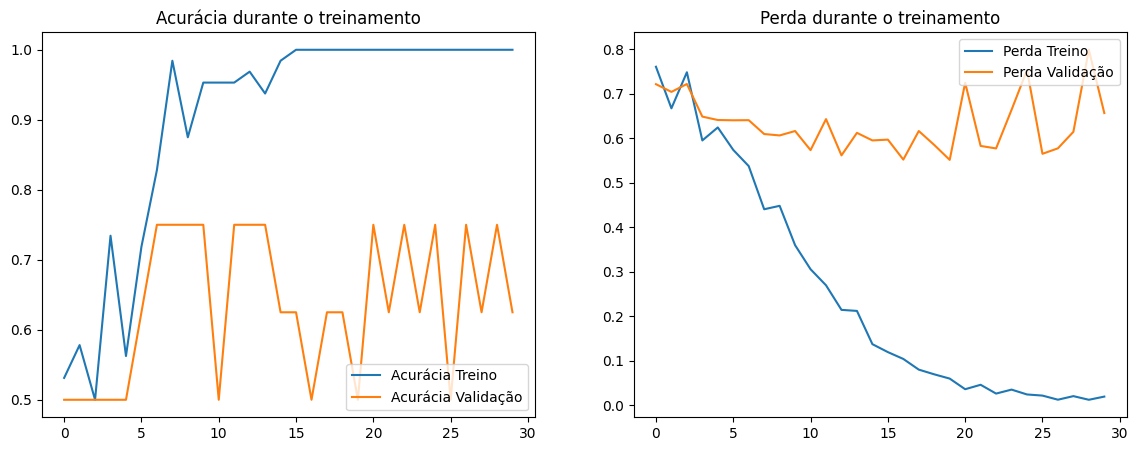

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia Treino')
    plt.plot(epochs_range, val_acc, label='Acurácia Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia durante o treinamento')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda Treino')
    plt.plot(epochs_range, val_loss, label='Perda Validação')
    plt.legend(loc='upper right')
    plt.title('Perda durante o treinamento')

    plt.show()

plot_training_history(history)


## COMPARATIVO DOS MODELOS